# Lab 8-2. CNN model의 활용 (2)

### 이번 실습은 torchvision 에 있는 Semantic Segmentation 모델들을 실행해보고 fine-tuning을 해보도록 하겠습니다.







### Drive mount and package import

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models




In [3]:
# data 경로 설정 
# root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
root = os.path.join(os.getcwd(), "drive", "MyDrive", "프로그래밍_교육", "쏘카 ai 엔지니어 육성 부트캠프 2기", "강의", "data")

### Dataset 준비


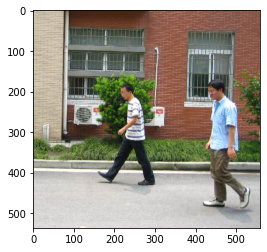

In [4]:
image = Image.open(os.path.join(root,'PennFudanPed/PNGImages/FudanPed00001.png'))
plt.imshow(image)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

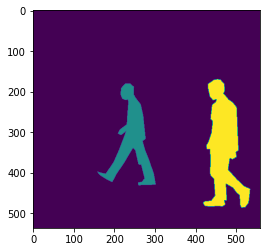

In [5]:
mask = Image.open(os.path.join(root,'PennFudanPed/PedMasks/FudanPed00001_mask.png'))
plt.imshow(mask)

np.array(mask)

In [6]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, mode='detection'):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
        self.mode = mode
        
        if not (self.mode == 'detection' or self.mode == 'segmentation'):
            raise ValueError(f"mode {self.mode} is not supproted")
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        
        
        if self.mode == 'detection':
            # instances are encoded as different colors
            obj_ids = np.unique(mask)
            # first id is the background, so remove it
            obj_ids = obj_ids[1:]

            # split the color-encoded mask into a set
            # of binary masks
            masks = mask == obj_ids[:, None, None]

            # get bounding box coordinates for each mask
            num_objs = len(obj_ids)
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target
        
        
        elif self.mode == 'segmentation':
            mask[mask > 0] = 1

            # there is only one class
            mask = torch.as_tensor(mask, dtype=torch.uint8)

            image_id = torch.tensor([idx])

            target = {}
            target["masks"] = mask
            target["image_id"] = image_id

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target

    def __len__(self):
        return len(self.imgs)

### Transforms

In [7]:
class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            if "boxes" in target:
                bbox = target["boxes"]
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        return image, target

class Resize(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, image, target):
        image = transforms.Resize(self.size)(image)
        if "masks" in target:
            target["masks"] = transforms.Resize(self.size)(target["masks"].unsqueeze(dim=0)).squeeze()
        return image, target

class Normalize(object):
    def __call__(self, image, target):
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [8]:
def get_transform(train):
    transforms = [ToTensor(), Resize((300,300)), Normalize()]
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

### Model

In [9]:
seg_model = models.segmentation.fcn_resnet50(pretrained=True)
seg_model

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

### Inference test

In [10]:
image = Image.open(os.path.join(root,'PennFudanPed/PNGImages/FudanPed00001.png'))
mask = Image.open(os.path.join(root,'PennFudanPed/PedMasks/FudanPed00001_mask.png'))


In [11]:
infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

input_image = infer_transform(image)

output = seg_model(input_image.unsqueeze(dim=0))

In [12]:
output['out'][0].shape

torch.Size([21, 536, 559])

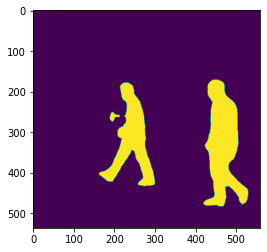

In [13]:
cls = torch.argmax(output['out'][0], dim=0).numpy()
out = np.zeros_like(cls)
out[cls==15] = 1
plt.imshow(out)

### Dataset split, DataLoader

In [14]:
dataset_segmentation = PennFudanDataset(os.path.join(root,'PennFudanPed/'), get_transform(train=True),mode='segmentation')

random_seed = 0
torch.manual_seed(random_seed)

val_size = int(len(dataset_segmentation) * 0.2)
train_size = len(dataset_segmentation) - val_size

train_dataset, valid_dataset = random_split(dataset_segmentation, [train_size, val_size])
print(len(train_dataset), len(valid_dataset))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, drop_last=True)


136 34


### Model 수정 
마지막 output 의 class 개수를 변경

In [15]:
seg_model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
seg_model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

### Trainer class 정의

In [16]:
## Trainer class 정의

class Semantic_Seg_Trainer(nn.Module):
    def __init__(self, model,opt="adam", lr=0.001, has_scheduler=False, device="cpu"):
        """
          Args:
            model: 사용할 model
            opt: optimizer
            lr: learning rate
            has_scheduler: learning rate scheduler 사용 여부
            device: 사용할 device (cpu/cuda)
        """
        super().__init__()

        self.model = model                            
        self.loss = nn.CrossEntropyLoss()             # loss function 정의

        self._get_optimizer(opt=opt.lower(), lr=lr)   # optimizer 정의
        self.has_scheduler = has_scheduler            # scheduler 사용여부 
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device                          # 사용할 device

    def _get_optimizer(self, opt, lr=0.001):
        """
          Args:
            opt: optimizer
            lr: learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
    #     self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5, visualize=False):
        """
          네트워크를 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
            valid_loader: validation에 사용할 dataloader
            max_epochs: 학습을 진행할 총 epoch 수
            disp_epochs: 학습 log를 display 할 epoch 주기
            visualize: 학습 진행 과정에서 결과 이미지를 visualize 
        """
        print("===== Train Start =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": []}
        for e in range(max_epochs):
            train_loss = self._train_epoch(train_loader)
            valid_loss = self._valid_epoch(valid_loader)

            history["train_loss"].append(train_loss)      # 현재 epoch에서 성능을 history dict에 저장
            history["valid_loss"].append(valid_loss)      #

            if self.has_scheduler:         # scheduler 사용할 경우 step size 조절
                self.scheduler.step()

            if e % disp_epoch == 0:        # disp_epoch 마다 결과값 출력 
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, time: {time.time()-start_time:>3f}")
                if visualize: 
                    self.vis_train_val()   # 현재 model에 대한 결과 이미지 plot 
                start_time = time.time()   

        self.plot_history(history)       # 그래프 출력

    def _train_epoch(self, train_loader):
        """
          model를 training set 한 epoch 만큼 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
          Returns:
            training set 한 epoch의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        self.model.train()                 # self.model을 train 모드로 전환 --> nn.Module의 내장함수
        for (x, y) in train_loader:        # x: data, y:label

            x = x.to(self.device)
            label = y['masks'].to(self.device).type(torch.long)
            
            out = self.model(x)              # model이 예측한 output
            loss = self.loss(out['out'], label)       

            self.optimizer.zero_grad()       # backwardpass를 통한 network parameter 업데이트
            loss.backward()                  # 
            self.optimizer.step()            # 
            
            epoch_loss += loss.to("cpu").item()    

        epoch_loss /= len(train_loader)  

        return epoch_loss
  
    def _valid_epoch(self, valid_loader):
        """
          현재 model의 성능을 validation set에서 측정하는 함수
          Args:
            valid_loader: 학습에 사용할 valid dataloader
          Returns:
            validation set 의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in valid_loader:
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                out = self.model(x) 
                loss = self.loss(out['out'], label)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(valid_loader)

        return epoch_loss

    def plot_history(self, history):
        """
          history에 저장된 model의 성능을 graph로 plot
          Args:
            history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
                     각 item 들은 epoch 단위의 성능 history의 list
        """
        fig = plt.figure(figsize=(10, 10))

        plt.plot(history["train_loss"], color="red", label="train loss")
        plt.plot(history["valid_loss"], color="blue", label="valid loss")
        plt.title("Loss")
        plt.legend()

        fig.show()

    def test(self, test_loader):
        """
          현재 model의 성능을 test set에서 측정하는 함수
          Args:
            test_loader: 학습에 사용할 test dataloader
          Returns:
            test set 의 평균 loss, 평균 accuracy
        """
        print("===== Test Start =====")
        start_time = time.time()
        epoch_loss = 0
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in test_loader:
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                out = self.model(x) 
                loss = self.loss(out['out'], label)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(test_loader)

        print(f"Test loss: {epoch_loss:>6f}, time: {time.time()-start_time:>3f}")
        self.vis_test()     # 결과 이미지 plot
    


### Fine-tuning

===== Train Start =====
Epoch: 0, train loss: 0.211256, valid loss: 0.155292, time: 128.911168
Epoch: 1, train loss: 0.115288, valid loss: 0.128296, time: 16.766443
Epoch: 2, train loss: 0.103914, valid loss: 0.128372, time: 16.834245
Epoch: 3, train loss: 0.086627, valid loss: 0.118487, time: 16.946882
Epoch: 4, train loss: 0.073908, valid loss: 0.108397, time: 17.008580
Epoch: 5, train loss: 0.063653, valid loss: 0.098948, time: 17.110795
Epoch: 6, train loss: 0.056545, valid loss: 0.100118, time: 17.244421
Epoch: 7, train loss: 0.050916, valid loss: 0.101525, time: 17.316697
Epoch: 8, train loss: 0.044833, valid loss: 0.106919, time: 17.545491
Epoch: 9, train loss: 0.042393, valid loss: 0.104767, time: 17.395405
Training time : 283.105692


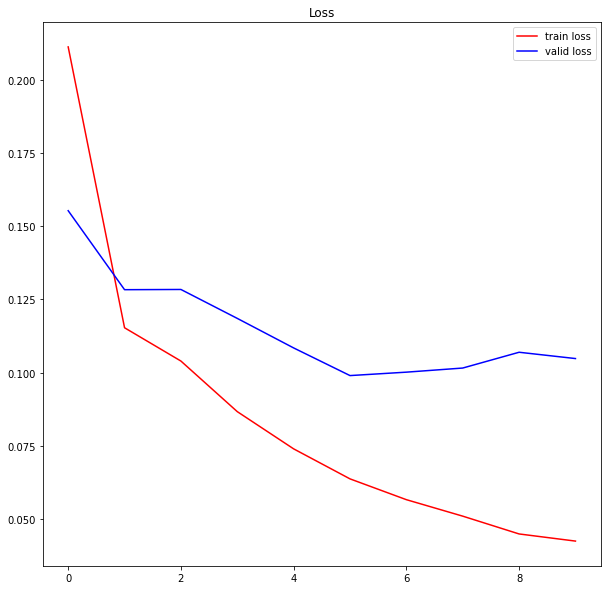

In [17]:
device = "cuda"
trainer = Semantic_Seg_Trainer(model=seg_model, opt="adam", lr=0.0001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)
print(f"Training time : {time.time()-start_time:>3f}")

### Fine-tuning 결과 테스트

In [18]:
image = Image.open(os.path.join(root,'PennFudanPed/PNGImages/FudanPed00001.png'))
mask = Image.open(os.path.join(root,'PennFudanPed/PedMasks/FudanPed00001_mask.png'))


infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

input_image = infer_transform(image).to(device)

output = seg_model(input_image.unsqueeze(dim=0))
output['out'].shape

torch.Size([1, 2, 536, 559])

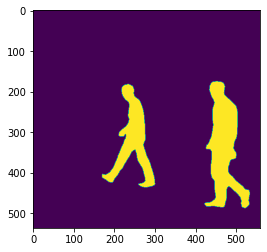

In [19]:
cls = torch.argmax(output['out'][0].to("cpu"), dim=0).numpy()
out = np.zeros_like(cls)
out[cls==1] = 1
plt.imshow(out)